### Example_Environmental_Engineering_Application

It is common in environmental data that we do not have a feature value in all the pixels in a map (latitudes and longitudes) and so the goal is to estimate unknown pixels with the known nearby ones. Another scenario is that the resolution of map is high and we are interested to reduce the resolution (due to the limitation in the computational resources) and so the goal is to minimize lossy compression. To tackle such problems, one idea is to employ the clustering algorithms (such K-Means) and then for each cluter assign the value of the cluster center to all the points that belong to that cluster. In what follows, we perfom this approch on Bare fraction and Elevation maps using both the K-means and the (developed) Affinity propagation algorithms. We train the clustering algorithms with a small random sample of original data and find the cluster centers and then predict which cluster each data point belongs to by finding the minimum Euclidean distance between them. Finally, we quantify the quality of the reduced map by using Kling Gupta Efficiency metric. Details of such analyses can be found in [[1]](https://github.com/chaneyn/ESDA_CEE690-02).



#### import Affinity Propagation Source Code

In [1]:
AffinityPackage_import_type=['load_installed_package','load_from_directory'][0]

In [2]:
if AffinityPackage_import_type=='load_installed_package':
    """pip install -i https://test.pypi.org/simple/ AffinityPropagation-RezaLevin2020-pkg-DukePhDs==0.0.3"""
    from AffinityPropagation_RezaLevin2020_pkg import Src_AP_V13 as AfP
else:
    """can be found in this repository: https://github.com/MReza89/Stat663_Spring2020_FinalProject_RezaLevin"""
    import Src_AP_V13 as AfP # requires to have Src_AP_V13.py in the current directory

#### import libraries related to testing

In [3]:
import sklearn.cluster as cluster
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import datasets
#from sklearn_extra.cluster import KMedoids
import seaborn as sns
sns.set_context('poster')
sns.set_color_codes()
import time

In [4]:
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

##### Data 

In [5]:
# functions for load or save a dictionary
import pickle
def save_obj(obj, obj_name):
    with open('.'+'/'+ obj_name+ '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(obj_name):
    with open('.'+'/'+ obj_name+'.pkl', 'rb') as f:
        return pickle.load(f)    

#### Data Visulaization Functions

In [6]:
def plot_2d_data(Data_X):
    plt.figure(figsize=(15, 6))        
    plt.scatter(Data_X[:, 0], Data_X[:, 1])
    plt.show()
    
    

### Environmental data

In [7]:
Envirnonmental_Data_dic=load_obj('Envirnonmental_Data')
Envirnonmental_Data_dic

{'dem': array([[1588.9183  , 1677.6432  , 1656.2432  , ..., 1611.0812  ,
         1609.4529  , 1607.8513  ],
        [1614.8094  , 1647.1166  , 1567.0974  , ..., 1607.8534  ,
         1606.7502  , 1605.412   ],
        [1571.3574  , 1543.9697  , 1545.6289  , ..., 1604.6162  ,
         1603.6112  , 1602.8593  ],
        ...,
        [ 112.668274,   94.585144,   83.91435 , ..., 2094.5278  ,
         1858.3633  , 1639.9668  ],
        [ 139.00487 ,  113.679   ,   91.71291 , ..., 1768.0704  ,
         1619.9907  , 1559.3394  ],
        [ 171.27051 ,  141.87949 ,  109.29649 , ..., 1536.9166  ,
         1409.3015  , 1334.4492  ]], dtype=float32),
 'ppt': array([[1247.77    , 1261.6675  , 1271.1284  , ...,  126.94334 ,
          127.1075  ,  127.2425  ],
        [1243.56    , 1258.9551  , 1277.145   , ...,  126.895004,
          127.055   ,  127.207504],
        [1228.3867  , 1249.72    , 1273.7289  , ...,  126.88333 ,
          127.06833 ,  127.229996],
        ...,
        [ 190.56    ,  18

In [8]:
#np.random.choice(np.arange(Envirnonmental_Data_dic['lat'].shape[0]),5000)
Envirnonmental_Data_dic['lat'].shape,Envirnonmental_Data_dic['dem'].shape

((200, 300), (200, 300))

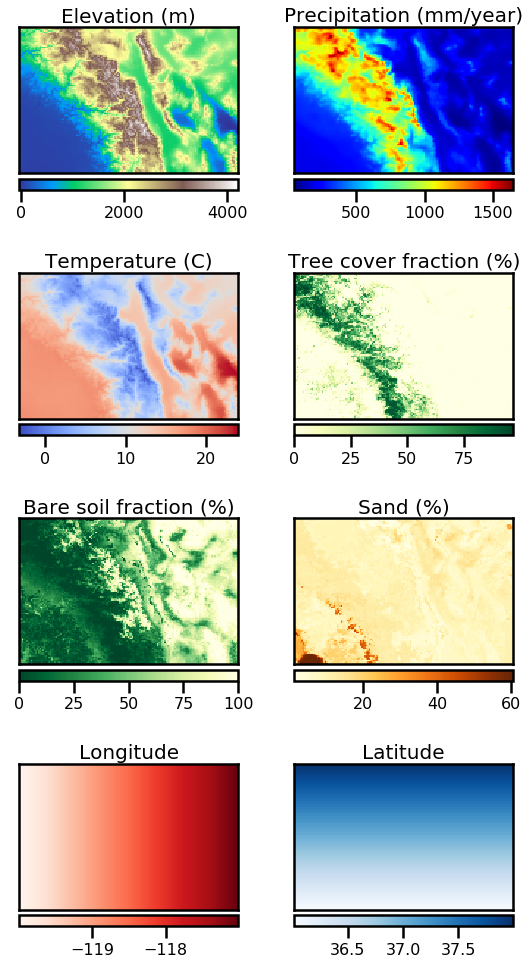

In [9]:
info = {'dem':{'cmap':'terrain','title':'Elevation (m)'},
        'ppt':{'cmap':'jet','title':'Precipitation (mm/year)'},
        'sand':{'cmap':'YlOrBr','title':'Sand (%)'},
        'tcf':{'cmap':'YlGn','title':'Tree cover fraction (%)'},
        'bcf':{'cmap':'YlGn_r','title':'Bare soil fraction (%)'},
        'tmean':{'cmap':'coolwarm','title':'Temperature (C)'},
        'lat':{'cmap':'Blues','title':'Latitude'},
        'lon':{'cmap':'Reds','title':'Longitude'}}
plt.figure(figsize=(8,14))
i = 0
for var in Envirnonmental_Data_dic:
    i += 1
    #print(i)
    plt.subplot(4,2,i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Envirnonmental_Data_dic[var][::2,::2],cmap=plt.get_cmap(info[var]['cmap']))
    cb = plt.colorbar(orientation='horizontal',pad=0.03)
    cb.ax.tick_params(labelsize=16)
    plt.title(info[var]['title'],fontsize=20)
plt.tight_layout()
plt.show()

### Focus: Bare cover fraction vs Elevation

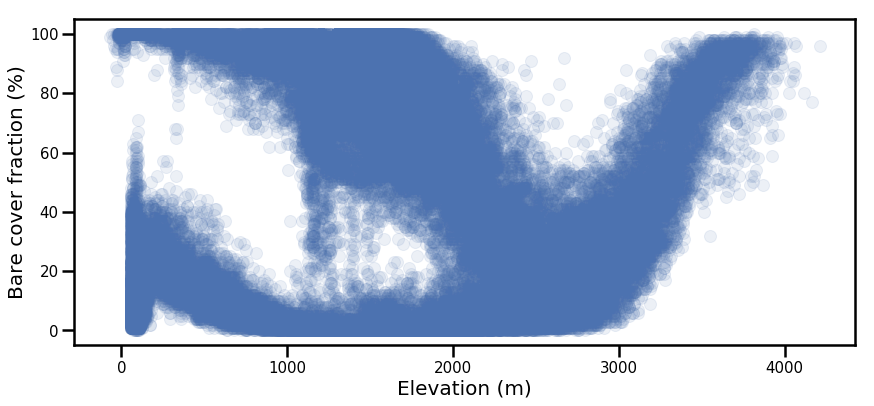

In [10]:
plt.figure(figsize=(14,6))
plt.plot(Envirnonmental_Data_dic['dem'],Envirnonmental_Data_dic['bcf'],'bo',alpha=0.1)
plt.xlabel('Elevation (m)',fontsize=20)
plt.ylabel('Bare cover fraction (%)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()        

We just use a small number of our data to fit the cluster

In [30]:
# 
N_Data_fit=1500
idx = np.random.choice(np.arange(Envirnonmental_Data_dic['dem'].size),N_Data_fit)
v1 = Envirnonmental_Data_dic['dem'].reshape(Envirnonmental_Data_dic['dem'].size)
v2 = Envirnonmental_Data_dic['bcf'].reshape(Envirnonmental_Data_dic['bcf'].size)
#Create data for scikit-learn
X = np.stack((v1,v2)).T
# standardize the data
Xn = (X - np.mean(X,axis=0))/(np.std(X,axis=0))
Xns = Xn[idx,:] # only part of data is used for fitting the model

vmin_dem = np.min(Envirnonmental_Data_dic['dem'])
vmax_dem = np.max(Envirnonmental_Data_dic['dem'])

vmin_bcf = np.min(Envirnonmental_Data_dic['bcf'])
vmax_bcf = np.max(Envirnonmental_Data_dic['bcf'])

## fit and prediction using K-Means

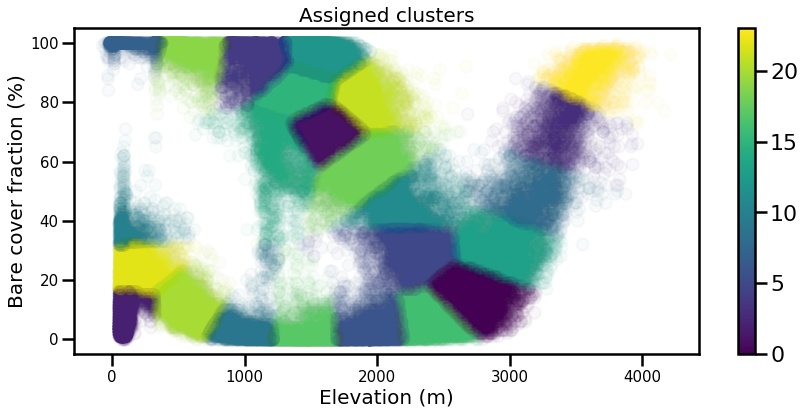

In [59]:

#Define the number of clusters
k = 24
np.random.seed(1)
model = cluster.KMeans(n_clusters=k)
#Subsample data to fit the model (minimize computation)
#Fit the model
model.fit(Xns)
#Predict the clusters on all the data
clusters_Kmeans = model.predict(Xn)
plt.figure(figsize=(14,6))
plt.title('Assigned clusters',fontsize=20)
plt.scatter(Envirnonmental_Data_dic['dem'].reshape(Envirnonmental_Data_dic['dem'].size),\
            Envirnonmental_Data_dic['bcf'].reshape(Envirnonmental_Data_dic['bcf'].size),
            c=clusters_Kmeans,cmap=plt.get_cmap('viridis'),alpha=0.03)
cb = plt.colorbar()
#Ensure the alpha of the colorbar is 1.0
cb.set_alpha(1.0)
cb.draw_all()
plt.xlabel('Elevation (m)',fontsize=20)
plt.ylabel('Bare cover fraction (%)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

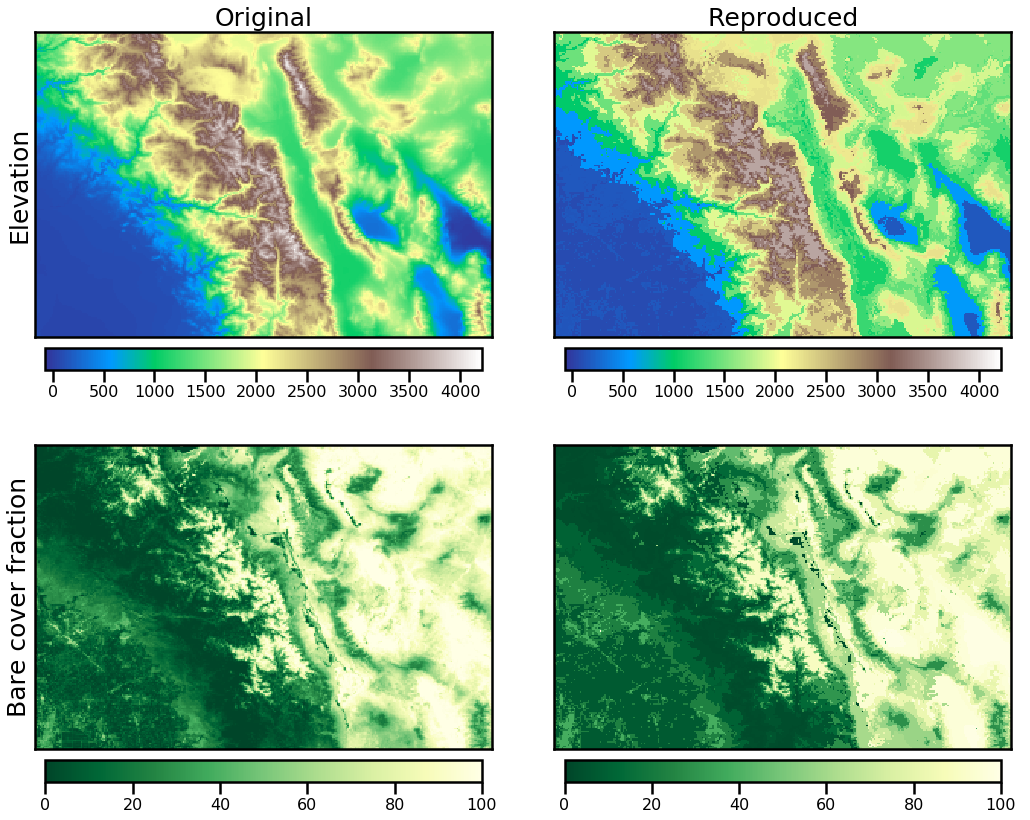

In [60]:
#Assign the cluster centroid values to each cluster
Xpred_Kmeans= np.copy(X)
for i in range(k):
    m = clusters_Kmeans == i
    Xpred_Kmeans[m,:] = np.mean(X[m,:],axis=0)
dem_pred_Kmeans = Xpred_Kmeans[:,0].reshape(Envirnonmental_Data_dic['dem'].shape)
bcf_pred_Kmeans = Xpred_Kmeans[:,1].reshape(Envirnonmental_Data_dic['bcf'].shape)
#Create a figure comparing them

plt.figure(figsize=(15,12))
plt.subplot(221)
plt.imshow(Envirnonmental_Data_dic['dem'],vmin=vmin_dem,vmax=vmax_dem,cmap=plt.get_cmap('terrain'))
plt.ylabel('Elevation',fontsize=25)
plt.title('Original',fontsize=25)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
plt.subplot(222)
plt.title('Reproduced',fontsize=25)
plt.imshow(dem_pred_Kmeans,vmin=vmin_dem,vmax=vmax_dem,cmap=plt.get_cmap('terrain'))
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)

plt.subplot(223)
plt.imshow(Envirnonmental_Data_dic['bcf'],vmin=vmin_bcf,vmax=vmax_bcf,cmap=plt.get_cmap('YlGn_r'))
plt.ylabel('Bare cover fraction',fontsize=25)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
plt.subplot(224)
plt.imshow(bcf_pred_Kmeans,vmin=vmin_bcf,vmax=vmax_bcf,cmap=plt.get_cmap('YlGn_r'))
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
plt.tight_layout()
plt.show()

## fit and prediction using developed Affinity Propagation

[   3   70   98  140  188  302  329  376  408  418  482  513  611  681
  744  786  797  811  841 1009 1124 1162 1317 1387] 299


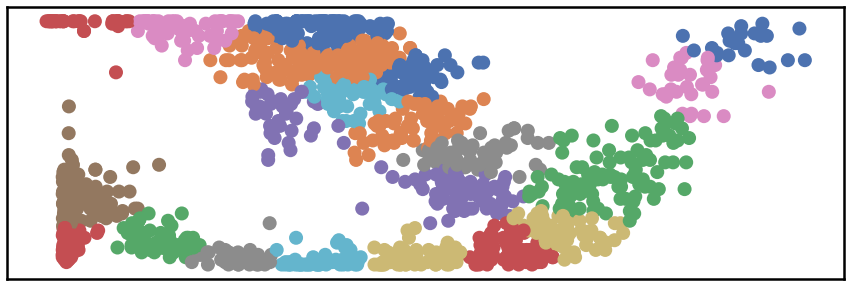

Wall time: 51.4 s


In [48]:
%%time
exemplars,labels,Cluster_Centers,last_iteration=AfP.affinity_propagation(Xns,preference=None,max_iter=400,Plot_Clusters=True)

In [49]:
last_iteration

299

In [50]:
from sklearn.metrics import pairwise_distances_argmin
def predict_cluster(Data_points,Cluster_centers):
    """ assigning each data point to a cluster by finding the minimum distance between each point and cluster centers"""
    return pairwise_distances_argmin(Data_points,Cluster_centers)

Now prediction

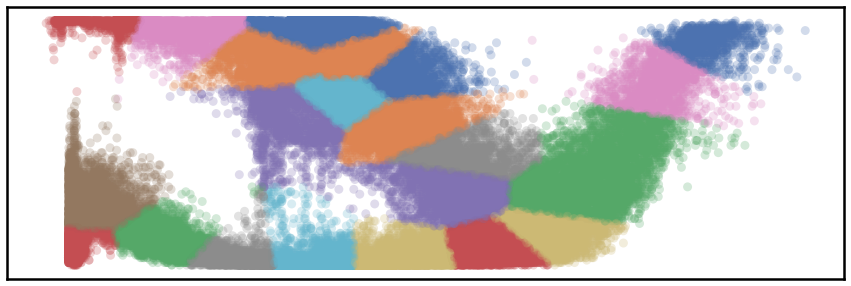

number of clusters found by affinity propagation= 24


In [51]:
Predicted_labels_AF=predict_cluster(Xn,Cluster_Centers)
AfP.plot_clusters(Xn,gapless_labels=Predicted_labels_AF,**plot_kwds )
print("number of clusters found by affinity propagation=",len(exemplars))

C:\Users\mrm132\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\mrm132\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


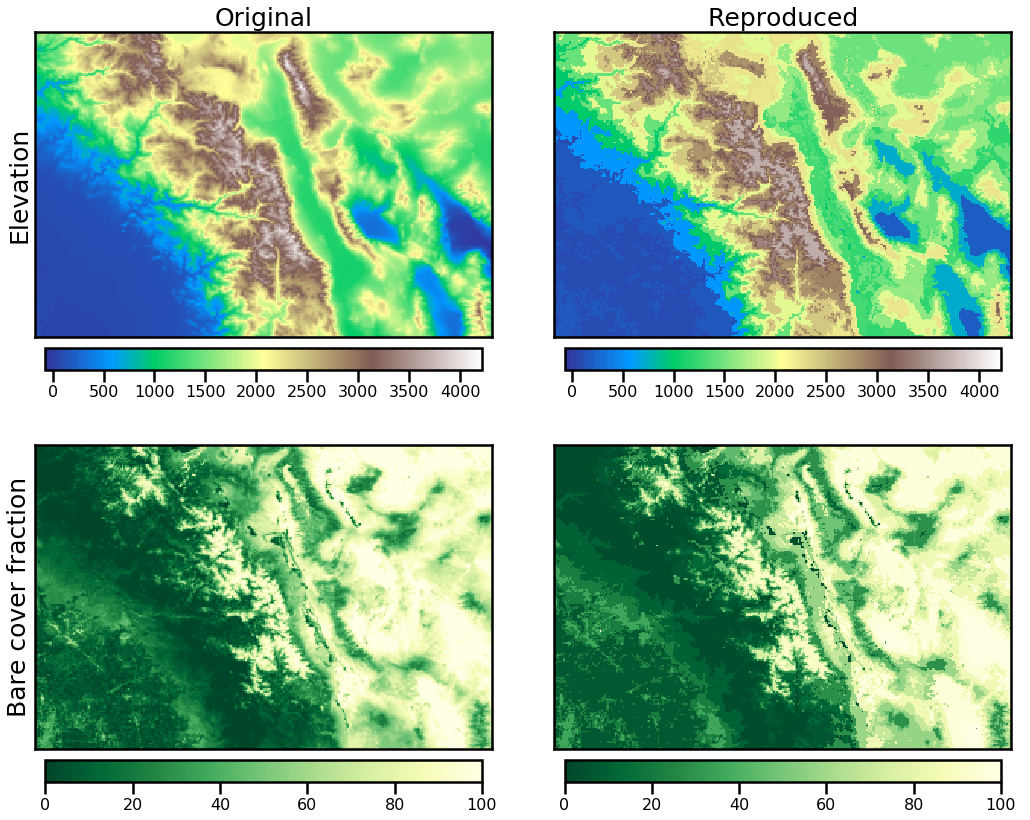

In [52]:
#Assign the cluster centroid values to each cluster
Xpred_AF = np.copy(X)
for i in range(k):
    m =  Predicted_labels_AF == i
    Xpred_AF[m,:] = np.mean(X[m,:],axis=0)
dem_pred_AF = Xpred_AF[:,0].reshape(Envirnonmental_Data_dic['dem'].shape)
bcf_pred_AF = Xpred_AF[:,1].reshape(Envirnonmental_Data_dic['bcf'].shape)
#Create a figure comparing them
plt.figure(figsize=(15,12))
plt.subplot(221)
plt.imshow(Envirnonmental_Data_dic['dem'],vmin=vmin_dem,vmax=vmax_dem,cmap=plt.get_cmap('terrain'))
plt.ylabel('Elevation',fontsize=25)
plt.title('Original',fontsize=25)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
plt.subplot(222)
plt.title('Reproduced',fontsize=25)
plt.imshow(dem_pred_AF,vmin=vmin_dem,vmax=vmax_dem,cmap=plt.get_cmap('terrain'))
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
vmin = np.min(Envirnonmental_Data_dic['bcf'])
vmax = np.max(Envirnonmental_Data_dic['bcf'])
plt.subplot(223)
plt.imshow(Envirnonmental_Data_dic['bcf'],vmin=vmin_bcf,vmax=vmax_bcf,cmap=plt.get_cmap('YlGn_r'))
plt.ylabel('Bare cover fraction',fontsize=25)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
plt.subplot(224)
plt.imshow(bcf_pred_AF,vmin=vmin_bcf,vmax=vmax_bcf,cmap=plt.get_cmap('YlGn_r'))
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
plt.tight_layout()
plt.show()

In our reasearch, we employ KGE, Kling Gupta Efficieny, as a metric to check the quality of the reduced map. This metric is defined as follows: 

<br>

$$\text{KGE} = 1 - \sqrt{(\rho-1)^2 + (\frac{\sigma_{org}}{\sigma_{sim}} - 1)^2 + (\frac{\mu_{org}}{\mu_{sim}} - 1)^2}$$

> Where $\rho$ is the Pearson correlation between the original and simulated maps, $\sigma_x$ is the standard deviation of a given map, and $\mu_x$ is the arithmetic mean of a given map.

In [57]:
import scipy
def calculate_kge(model,obs):
    rho = scipy.stats.pearsonr(model.reshape(model.size),obs.reshape(obs.size))[0]
    alpha = np.std(obs)/np.std(model)
    beta = np.mean(obs)/np.mean(model)
    kge = 1 - ((1-rho)**2 + (1-alpha)**2 + (1-beta)**2)**0.5
    return kge

In [61]:
print("KGE for the Elevation map using Affinity Propagation = \n",calculate_kge(Envirnonmental_Data_dic['dem'],dem_pred_AF))
print("KGE for the Elevation map using K-means = \n",calculate_kge(Envirnonmental_Data_dic['dem'],dem_pred_Kmeans))

print("KGE for the Bare cover fraction map using Affinity Propagation= \n",calculate_kge(Envirnonmental_Data_dic['bcf'],bcf_pred_AF))
print("KGE for the Bare cover fraction map using K-means= \n",calculate_kge(Envirnonmental_Data_dic['bcf'],bcf_pred_Kmeans))


KGE for the Elevation map using Affinity Propagation = 
 0.9842482054206472
KGE for the Elevation map using K-means = 
 0.9851347222312528
KGE for the Bare cover fraction map using Affinity Propagation= 
 0.9850951928768353
KGE for the Bare cover fraction map using K-means= 
 0.9849200224655511


These results indicate that Affinity Propagation can find 24 clusters when we set the preference as default value (median of the similarity matrix). It has almost the same performance as K-means when we train it with the same number of clusters. The advantage of Affinity Propagation is that the cluster centers (exemplars) are selected from the input data points and also we do not need to specify number of clusters apriority. 
